# Changing Functions of the Taxes and Transfers System

This tutorial focuses on the policy functions of GETTSIM, one of the two objects returned by the function `set_up_policy_environment`. Alongside policy parameters, these functions help GETTSIM define a date-specific policy environment based on which it can compute taxes and transfers for individual and household data. 

Just like [parameters](parameters.ipynb), policy functions can be replaced, added or removed to make changes to the existing policy environment. This way, you can design a new tax or transfer for any specific group of people, e.g. invent a new tax for people that have income from renting an apartment, or change the conditions for receiving already existing transfers.

In [1]:
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gettsim import set_up_policy_environment
from gettsim import compute_taxes_and_transfers

<IPython.core.display.Javascript object>

## Changing  & replacing existing function(s)

### Example: Receiving multiple transfers

In the German system, there are some transfers for low-income families that cannot be received in combination. Per default, GETTSIM will always choose the most favorable transfers and set other transfers to zero. This assumption could model the behavior of households/families in a wrong way, if they do not always choose the optimal transfers (from a monetary perspective). For example, there could be a social stigma connected to certain transfers or some people simply do not know about some of the available transfers.

To account for these frictions, we can turn off this aspect of GETTSIM so that we see all the transfers a family/household is entitled to, even if the transfers cannot be received in combination. This can be useful for further analysis. For example you could speculate which transfers Germans receive in reality and implement this in GETTSIM.

### Find the Function

[Here](../functions.rst) we can look for the function that implements the aspect we want to change.

In [2]:
policy_params, policy_functions = set_up_policy_environment("2020")

<IPython.core.display.Javascript object>

### Define Changes to the Function

After you found the function that you want to change, copy the source code from the website to your notebook and change it just as you like:

In [3]:
def arbeitsl_geld_2_m_hh(
    arbeitsl_geld_2_m_minus_eink_hh,
    wohngeld_vorrang_hh,
    kinderzuschlag_vorrang_hh,
    wohngeld_kinderzuschlag_vorrang_hh,
    rentner_in_hh,
):
    out = arbeitsl_geld_2_m_minus_eink_hh.clip(lower=0)
    cond = (
        # wohngeld_vorrang_hh
        # | kinderzuschlag_vorrang_hh
        # | wohngeld_kinderzuschlag_vorrang_hh
        rentner_in_hh
    )
    out.loc[cond] = 0
    return out

<IPython.core.display.Javascript object>

The lines of the cell above that start with "#" usually do the priority check as described above. With the hash, the lines become a comment and do not influence the code anymore.

### Make GETTSIM incorporate your Changes 

There are different ways to make GETTSIM incorporate your edited function. 

#### Alternative 1:

One way is to copy the `policy_functions` and replace the "old" function with the function we defined before.

In [4]:
policy_functions_no_check = copy.deepcopy(policy_functions)
policy_functions_no_check["arbeitsl_geld_2_m_hh"] = arbeitsl_geld_2_m_hh

<IPython.core.display.Javascript object>

Computations with the new `policy_functions_no_check` will now have the characteristic of showing the value of all available transfers without checking which ones cannot be received in combination and without choosing the most profitable combination. 

Let´s test if this works! 

We import simulated data for households with two parents and three children. These households only vary in their income:

In [5]:
data = pd.read_csv("household_data_favorability.csv")
data.head(5)

,p_id,hh_typ,hh_id,tu_id,bruttolohn_m,bruttolohn_vorj_m,arbeitsl_lfdj_m,arbeitsl_vorj_m,arbeitsl_vor2j_m,arbeitsstunden_w,...,prv_rente_beitr_m,miete_unterstellt,kapital_eink_m,vermiet_eink_m,jahr_renteneintr,in_ausbildung,behinderungsgrad,alleinerziehend,mietstufe,sonstig_eink_m
0,2004,"2 adults, 3 children",1002,1002,0.0,0.0,0,0,0,5.0,...,0,0,0,0,2061,False,0,False,5,0
1,2005,"2 adults, 3 children",1002,1002,250.0,0.0,0,0,0,5.0,...,0,0,0,0,2061,False,0,False,5,0
2,2006,"2 adults, 3 children",1002,1002,250.0,0.0,0,0,0,5.0,...,0,0,0,0,2061,False,0,False,5,0
3,2007,"2 adults, 3 children",1002,1002,0.0,0.0,0,0,0,5.0,...,0,0,0,0,2061,False,0,False,5,0
4,2008,"2 adults, 3 children",1002,1002,0.0,0.0,0,0,0,5.0,...,0,0,0,0,2061,False,0,False,5,0


<IPython.core.display.Javascript object>

For this data we can now compare the results of using GETTSIM with the `policy_functions_no_check` and the usual `policy_functions`. 

We should expect to see positive values for `wohngeld_m_hh`, `kinderzuschlag_m_hh` and `arbeitsl_geld_2_m_hh` at the same time if we do not check which combination of transfers is optimal (`policy_functions_no_check`).

On the other hand, if we use the default version of the `policy_functions`, `wohngeld_m_hh` and `kinderzuschlag_m_hh` should be zero as long as `arbeitsl_geld_2_m_hh` is positive (and the other way around), as it is a characteristic of the German taxes and transfers system that *Wohngeld* and *Kinderzuschlag* cannot be received in combination with *Arbeitslosengeld 2*.

In [6]:
targets = ["wohngeld_m_hh", "kinderzuschlag_m_hh", "arbeitsl_geld_2_m_hh"]

<IPython.core.display.Javascript object>

In [7]:
policies = {
    "Checked Favorability": policy_functions,
    "No Check of Favorabilty": policy_functions_no_check,
}

<IPython.core.display.Javascript object>

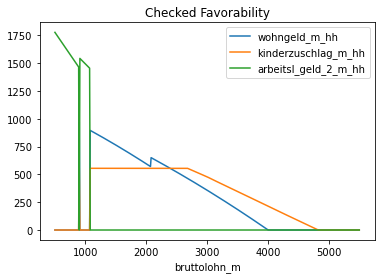

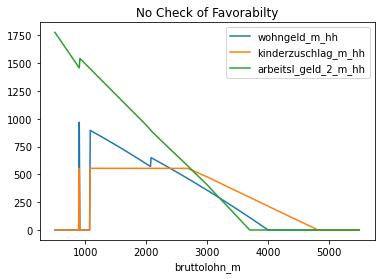

<IPython.core.display.Javascript object>

In [8]:
# Loop through keys to plot both scenarios.
for k in policies:
    # Compute taxes and transfers.
    result = compute_taxes_and_transfers(
        data=data, functions=policies[k], params=policy_params, targets=targets
    )
    # Add earnings and index to result DataFrame.
    result["bruttolohn_m"] = data["bruttolohn_m"]
    result.index = data["hh_id"]
    # Create DataFrame that contains the maximum value of the target variables
    # in the household and the household gross income.
    result = (
        result.groupby("hh_id")[targets]
        .max()
        .join(result.groupby("hh_id")["bruttolohn_m"].sum())
    )
    # Plot the results.
    result.plot(x="bruttolohn_m", title=k)

On first glance, both figures look quite confusing because of the complexity of the German taxes and transfers system. But if we take a closer look, the figures confirm our expectations. If we let GETTSIM check for the most favorable combination of transfers, ```wohngeld_m_hh``` and ```kinderzuschlag_m_hh``` are zero as long as `arbeitsl_geld_2_m_hh` is positive(i.e. the best option for the household) and the other way around. 

If we do not let GETTSIM do this check, this does not hold any longer and all transfers can be positive at the same time (which is what we were trying to achieve). 

#### Alternative 2:

Another way would be to mention the changed function in our ```compute_taxes_and_transfers```-function. This works as follows: 

In [9]:
result_no_check_p = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    functions=[policy_functions, arbeitsl_geld_2_m_hh],
    targets=["wohngeld_m_hh", "kinderzuschlag_m_hh", "arbeitsl_geld_2_m_hh",],
)

<IPython.core.display.Javascript object>

Executing this cell will allow you to reproduce the same analysis we did above. We do not want to do it twice, so we skip it. 

There are three important points:

1. Note that ```arbeitsl_geld_2_m_hh``` has the same function name as a pre-defined function inside GETTSIM. Thus, the internal function will be replaced with this version.

2. In general, if there are multiple functions with the same name, internal functions have the lowest precedence. After that, the elements in the list passed to the ```functions``` argument are evaluated element by element. The functions in the leftmost element have the lowest precedence and the functions in the rightmost element have the highest.

3. If ```policy_functions``` would not be necessary for this example, you can also directly pass the ```arbeitsl_geld_2_m_hh``` function to the ```functions``` argument.

### Multiple Functions

You can use exactly the same approach if you want to change more than one function of GETTSIM. But first, for our example we need to invent some changes to another function of GETTSIM. Imagine, we want to double the amount of *Kindergeld* every household receives in addition to the previously implemented function change.

In [10]:
def kindergeld_m_hh(kindergeld_m, hh_id):
    """Aggregate child benefit on the household level.

    Aggregate child benefit on the household level, as we could have several tax_units
    in one household.

    Parameters
    ----------
    kindergeld_m
    hh_id

    Returns
    -------

    """
    return kindergeld_m.groupby(hh_id).sum() * 2

<IPython.core.display.Javascript object>

If you edit ```arbeitsl_geld_2_m_hh``` and ```kindergeld_m_hh```, your two options to make GETTSIM incorporate your changes would be:

**Alternative 1:**

In [11]:
policy_functions_reformed = copy.deepcopy(policy_functions)
policy_functions_reformed["arbeitsl_geld_2_m_hh"] = arbeitsl_geld_2_m_hh
policy_functions_reformed["kindergeld_m_hh"] = kindergeld_m_hh

<IPython.core.display.Javascript object>

 **Alternative 2:**

In [12]:
df = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    functions=[policy_functions, arbeitsl_geld_2_m_hh, kindergeld_m_hh],
    targets=[
        "wohngeld_m_hh",
        "kinderzuschlag_m_hh",
        "arbeitsl_geld_2_m_hh",
        "kindergeld_m_hh",
    ],
)

<IPython.core.display.Javascript object>

## Adding a new function

### Define Function

One transfer that does not exist in reality, but is easy to implement in GETTSIM could be a unconditional basic income for every citizen. Every household receives the unconditional basic income multiplied by the size of the household. We set the unconditional basic income to 1000€ per month: 

In [13]:
def basic_income_m_hh(hh_id):
    """Compute household basic income of 1000€ per month per individual."""
    return hh_id.groupby(hh_id).size() * 1000

<IPython.core.display.Javascript object>

Maybe it can be helpful to use an [existing function](../functions.rst) as a template and change the parameters and the body of the function accordingly.

### Add Function to Dictionary

In [14]:
policy_functions_with_basic_income = copy.deepcopy(policy_functions)
policy_functions_with_basic_income["basic_income_m_hh"] = basic_income_m_hh

<IPython.core.display.Javascript object>

### (Check if it Works)

We can define some exemplary data easily. All we need is a  ```p_id``` and a ```hh_id```. Everything else is irrelevant for this example, because the transfer does not depend on any conditions. As a result we should see 4000€, because the simulated household has four members.

In [15]:
# Create small example household with four individuals.
data = pd.DataFrame({"p_id": np.arange(0, 4), "hh_id": 1})
data

,p_id,hh_id
0,0,1
1,1,1
2,2,1
3,3,1


<IPython.core.display.Javascript object>

In [16]:
df = compute_taxes_and_transfers(
    data=data,
    functions=policy_functions_with_basic_income,
    params=policy_params,
    targets="basic_income_m_hh",
)
df

,basic_income_m_hh
0,4000
1,4000
2,4000
3,4000


<IPython.core.display.Javascript object>

Looks like we implemented our new transfer correctly!